optimization with [NAG]
epoch: [0000], cost: [000.0521]
epoch: [0001], cost: [000.0047]
epoch: [0002], cost: [000.0033]
epoch: [0003], cost: [000.0027]
epoch: [0004], cost: [000.0024]
epoch: [0005], cost: [000.0022]
epoch: [0006], cost: [000.0021]
epoch: [0007], cost: [000.0020]
epoch: [0008], cost: [000.0019]
epoch: [0009], cost: [000.0019]
epoch: [0010], cost: [000.0018]
epoch: [0011], cost: [000.0018]
epoch: [0012], cost: [000.0017]
epoch: [0013], cost: [000.0017]
epoch: [0014], cost: [000.0017]
epoch: [0015], cost: [000.0016]
epoch: [0016], cost: [000.0016]
epoch: [0017], cost: [000.0016]
epoch: [0018], cost: [000.0016]
epoch: [0019], cost: [000.0016]
epoch: [0020], cost: [000.0015]
epoch: [0021], cost: [000.0015]
epoch: [0022], cost: [000.0015]
epoch: [0023], cost: [000.0015]
epoch: [0024], cost: [000.0014]
epoch: [0025], cost: [000.0014]
epoch: [0026], cost: [000.0014]
epoch: [0027], cost: [000.0014]
epoch: [0028], cost: [000.0014]
epoch: [0029], cost: [000.0014]
Training accurac

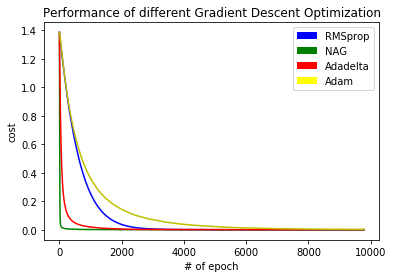

In [1]:
import sys
import numpy as np
import math
import random

import matplotlib

#matplotlib.use('wx')
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

plt_color_array = ['blue', 'green', 'red', 'yellow']
plt_dict = dict()

sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
random.seed(1024 * 1024)

num_feature = 123

train_path = 'data/mnist.train'
test_path = 'data/mnist.test'
opt_algo_set = [ 'NAG', 'RMSprop','Adadelta', 'Adam']





class logisticregression:
    def __init__(self, num_input):
        self.num_input = num_input
        self.num_output = 2

    def train(self, x, y, opt_algo, num_epoch=30, mini_batch=100, lambda_=0.01):
        if not opt_algo in opt_algo_set:
            print >> sys.stderr, 'opt_algo not in %s' % opt_algo_set
            return
        print >> sys.stderr, 'optimization with [%s]' % opt_algo

        num_params = 1 * (self.num_input + 1) + self.num_output * 2
        w = np.matrix(0.005 * np.random.random([num_params, 1]))
        data = np.column_stack([x, y])

        gamma = 0.9
        epsilon = 1e-8

        if opt_algo == 'RMSprop' or opt_algo == 'Adam':
            eta = 0.001
        else:
            eta = 0.05

        v = np.matrix(np.zeros(w.shape))
        m = np.matrix(np.zeros(w.shape))

        # Adam params
        beta1 = 0.9
        beta2 = 0.999
        beta1_exp = 1.0
        beta2_exp = 1.0

        # Adagrad params
        grad_sum_square = np.matrix(np.zeros(w.shape))

        # Adadelta & RMSprop params
        grad_expect = np.matrix(np.zeros(w.shape))
        delta_expect = np.matrix(np.zeros(w.shape))

        first_run = True
        for epoch in range(num_epoch):
            np.random.shuffle(data)
            k = 0
            cost_array = list()
            while k < len(data):
                x = data[k: k + mini_batch, 0: -1]
                y = np.matrix(data[k: k + mini_batch, -1], dtype='int32')
                if opt_algo == 'SGD':
                    # Stochastic gradient descent
                    cost, grad = self.gradient(x, y, lambda_, w)
                    w = w - eta * grad

                elif opt_algo == 'Momentum':
                    # Momentum
                    cost, grad = self.gradient(x, y, lambda_, w)
                    v = gamma * v + eta * grad
                    w = w - v

                elif opt_algo == 'NAG':
                    # Nesterov accelerated gradient
                    cost, grad = self.gradient(x, y, lambda_, w - gamma * v)
                    v = gamma * v + eta * grad
                    w = w - v

                elif opt_algo == 'Adagrad':
                    # Adagrad
                    cost, grad = self.gradient(x, y, lambda_, w)
                    grad_sum_square += np.square(grad)
                    delta = - eta * grad / np.sqrt(grad_sum_square + epsilon)
                    w = w + delta

                elif opt_algo == 'Adadelta':
                    # Adadelta
                    cost, grad = self.gradient(x, y, lambda_, w)
                    grad_expect = gamma * grad_expect + (1.0 - gamma) * np.square(grad)
                    # when first run, use sgd
                    if first_run == True:
                        delta = - eta * grad
                    else:
                        delta = - np.multiply(np.sqrt(delta_expect + epsilon) / np.sqrt(grad_expect + epsilon), grad)
                    w = w + delta
                    delta_expect = gamma * delta_expect + (1.0 - gamma) * np.square(delta)

                elif opt_algo == 'RMSprop':
                    # RMSprop
                    cost, grad = self.gradient(x, y, lambda_, w)
                    grad_expect = gamma * grad_expect + (1.0 - gamma) * np.square(grad)
                    w = w - eta * grad / np.sqrt(grad_expect + epsilon)

                elif opt_algo == 'Adam':
                    # Adam
                    cost, grad = self.gradient(x, y, lambda_, w)
                    m = beta1 * m + (1.0 - beta1) * grad
                    v = beta2 * v + (1.0 - beta2) * np.square(grad)
                    beta1_exp *= beta1
                    beta2_exp *= beta2
                    w = w - eta * (m / (1.0 - beta1_exp)) / (np.sqrt(v / (1.0 - beta2_exp)) + epsilon)

                k += mini_batch
                cost_array.append(cost)
                if first_run == True: first_run = False

            if not opt_algo in plt_dict:
                plt_dict[opt_algo] = list()
            plt_dict[opt_algo].extend(cost_array)
            print >> sys.stderr, 'epoch: [%04d], cost: [%08.4f]' % (epoch, sum(cost_array) / len(cost_array))

        self.w1 = w[0:  (self.num_input + 1)].reshape(1, self.num_input + 1)
        self.w2 = w[(self.num_input + 1):].reshape(self.num_output, 2)

    def gradient(self, x, y, lambda_, w):
        # x = data[:, 0: -1]
        # y = np.matrix(data[:, -1], dtype='int32')
        num_sample = len(x)

        w1 = w[0: (self.num_input + 1)].reshape(1, self.num_input + 1)
        w2 = w[(self.num_input + 1):].reshape(self.num_output, 2)
        b = np.matrix(np.ones([num_sample, 1]))

        a1 = np.column_stack([x, b])
        s2 = sigmoid(a1 * w1.T)
        a2 = np.column_stack([s2, b])
        a3 = sigmoid(a2 * w2.T)

        y_one_hot = np.matrix(np.zeros([num_sample, self.num_output]))
        y_one_hot[(np.matrix(range(num_sample)), y.T)] = 1

        cost = (1.0 / num_sample) * (
        - np.multiply(y_one_hot, np.log(a3)) - np.multiply(1.0 - y_one_hot, np.log(1.0 - a3))).sum()
        cost += (lambda_ / (2.0 * num_sample)) * (np.square(w1[:, 0: -1]).sum() + np.square(w2[:, 0: -1]).sum())

        delta3 = a3 - y_one_hot
        delta2 = np.multiply(delta3 * w2[:, 0: -1], np.multiply(s2, 1.0 - s2))
        l1_grad = delta2.T * a1
        l2_grad = delta3.T * a2

        r1_grad = np.column_stack([w1[:, 0: -1], np.matrix(np.zeros([1, 1]))])
        r2_grad = np.column_stack([w2[:, 0: -1], np.matrix(np.zeros([self.num_output, 1]))])

        w1_grad = (1.0 / num_sample) * l1_grad + (1.0 * lambda_ / num_sample) * r1_grad
        w2_grad = (1.0 / num_sample) * l2_grad + (1.0 * lambda_ / num_sample) * r2_grad
        w_grad = np.row_stack([w1_grad.reshape(-1, 1), w2_grad.reshape(-1, 1)])

        return cost, w_grad

    def predict(self, x):
        num_sample = len(x)
        b = np.matrix(np.ones([num_sample, 1]))
        h1 = sigmoid(np.column_stack([x, b]) * self.w1.T)
        h2 = sigmoid(np.column_stack([h1, b]) * self.w2.T)
        return np.argmax(h2, 1)

    def test(self, x, y):
        num_sample = len(x)
        y_pred = self.predict(x)
        y_one_hot = (np.zeros(y.shape))
        y_one_hot[np.where(y_pred == y)[0]] = 1
        acc = 1.0 * y_one_hot.sum() / num_sample
        return acc


from sklearn.datasets import load_svmlight_file
data = load_svmlight_file("/home/qian/iNet/PycharmProjects/ML-lab2/a9a",query_id=True)
x_train=data[0].todense()
y_train=data[1]
datatest=load_svmlight_file("/home/qian/iNet/PycharmProjects/ML-lab2/a9a.t",query_id=True,n_features=123)
x_test=datatest[0].todense()
y_test=datatest[1]
# # z_score_normalize
# mean = x_train.mean(0)
# std = x_train.std(0)
# x_train = 1.0 * (x_train - mean) / (std + 0.0001)
# x_test = 1.0 * (x_test - mean) / (std + 0.0001)

clf = logisticregression(num_feature)

for opt_algo in opt_algo_set:
    clf.train(x_train, y_train, opt_algo)
    acc_train = clf.test(x_train, y_train)
    print >> sys.stderr, 'Training accuracy: %lf%%' % (100.0 * acc_train),'of',opt_algo
    acc_test = clf.test(x_test, y_test)
    print >> sys.stderr, 'Test accuracy: %lf%%' % (100.0 * acc_test),'of',opt_algo

plt.subplot(111)
plt.title('Performance of different Gradient Descent Optimization')
plt.xlabel('# of epoch')
plt.ylabel('cost')
# plt.xlim(0.0, 9.0)# set axis limits
# plt.ylim(0.0, 30.)

proxy = list()
legend_array = list()
for index, (opt_algo, epoch_cost) in enumerate(plt_dict.items()):
    selected_color = plt_color_array[index % len(plt_color_array)]
    plt.plot(range(len(epoch_cost)), epoch_cost, '-%s' % selected_color[0])
    proxy.append(Rectangle((0, 0), 0, 0, facecolor=selected_color))
    legend_array.append(opt_algo)
plt.legend(proxy, legend_array)
plt.show()